In [56]:
# Core libraries
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, 
    Dense, 
    Conv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    Flatten, 
    Reshape, 
    BatchNormalization, 
    Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [58]:
def load_and_preprocess_data(add_noise=True, noise_factor=0.2):
    (x_train, _), (x_test, _) = cifar10.load_data()
    x_train = x_train.astype('float32') / 255.0
    x_test = x_test.astype('float32') / 255.0
    print(f"Training data shape: {x_train.shape}")
    print(f"Test data shape: {x_test.shape}")
    
    x_train_noisy = x_train.copy()
    x_test_noisy = x_test.copy()
    
    # Add random Gaussian noise if requested
    if add_noise:
        x_train_noisy = x_train_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
        x_test_noisy = x_test_noisy + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
        
    # Clip the values to be between 0 and 1
    x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
    x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)
    
    return x_train_noisy, x_train, x_test_noisy, x_test

In [70]:
x_train_noisy, x_train, x_test_noisy, x_test = load_and_preprocess_data()

Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


In [60]:
def build_autoencoder(input_shape=(32, 32, 3), encoding_dim=256):
    input_dim = np.prod(input_shape)
    input_img = Input(shape=input_shape)
    flat_img = Flatten()(input_img)
    encoded = Dense(512, activation='relu')(flat_img)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    
    decoded = Dense(512, activation='relu')(encoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    output_img = Reshape(input_shape)(decoded)
    
    autoencoder = Model(input_img, output_img)
    encoder = Model(input_img, encoded)
    
    encoded_input = Input(shape=(encoding_dim,))
    decoder_layers = autoencoder.layers[-3](encoded_input)
    decoder_layers = autoencoder.layers[-2](decoder_layers) 
    decoder_output = Reshape(input_shape)(decoder_layers)
    decoder = Model(encoded_input, decoder_output)
    
    return autoencoder, encoder, decoder
    

In [62]:
def build_convolutional_autoencoder(input_shape=(32, 32, 3)):
    # Input layer
    input_img = Input(shape=input_shape)
    
    # Encoder
    x = Conv2D(32, (3, 3), padding='same')(input_img)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x) # 16x16x32
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), padding='same')(x) # 8x8x64
    
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x) # 4x4x128
    
    # Decoder
    x = Conv2D(128, (3, 3), padding='same')(encoded)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x) # 8x8x128
    
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x) # 16x16x64
    
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((2, 2))(x) # 32x32x32
    
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) # 32x32x3
    
    # Create the autoencoder model
    autoencoder = Model(input_img, decoded)
    
    # Create the encoder model
    encoder = Model(input_img, encoded)
    
    # Create the decoder model
    encoded_input = Input(shape=(4, 4, 128))
    
    # Get the decoder layers from the autoencoder
    decoder_layers = autoencoder.layers[-13:]
    
    # Build the decoder model
    x = encoded_input
    for layer in decoder_layers:
        x = layer(x)
    decoder = Model(encoded_input, x)
    
    return autoencoder, encoder, decoder

In [64]:
def train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, batch_size=128, epochs=50):
    # Compile the model
    autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    
    # Use early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model
    history = autoencoder.fit(
        x_train_noisy, x_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(x_test_noisy, x_test),
        callbacks=[early_stopping]
    )
    
    return history

In [66]:
def evaluate_autoencoder(autoencoder, x_test_noisy, x_test):
    test_loss = autoencoder.evaluate(x_test_noisy, x_test)
    print(f"Test loss (MSE): {test_loss}")
    return test_loss

In [68]:
def plot_reconstructed_images(autoencoder, x_test_noisy, x_test, n=10):
    reconstructed_imgs = autoencoder.predict(x_test_noisy[:n])
    
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test[i])
        plt.title("Original")
        plt.axis("off")
        
        # Noisy image
        ax = plt.subplot(3, n, i + n + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Noisy") 
        plt.axis("off")
        
        # Reconstructed image
        ax = plt.subplot(3, n, i + 2*n + 1)
        plt.imshow(reconstructed_imgs[i])
        plt.title("Reconstructed")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

Loading and preprocessing CIFAR-10 data...
Training data shape: (50000, 32, 32, 3)
Test data shape: (10000, 32, 32, 3)


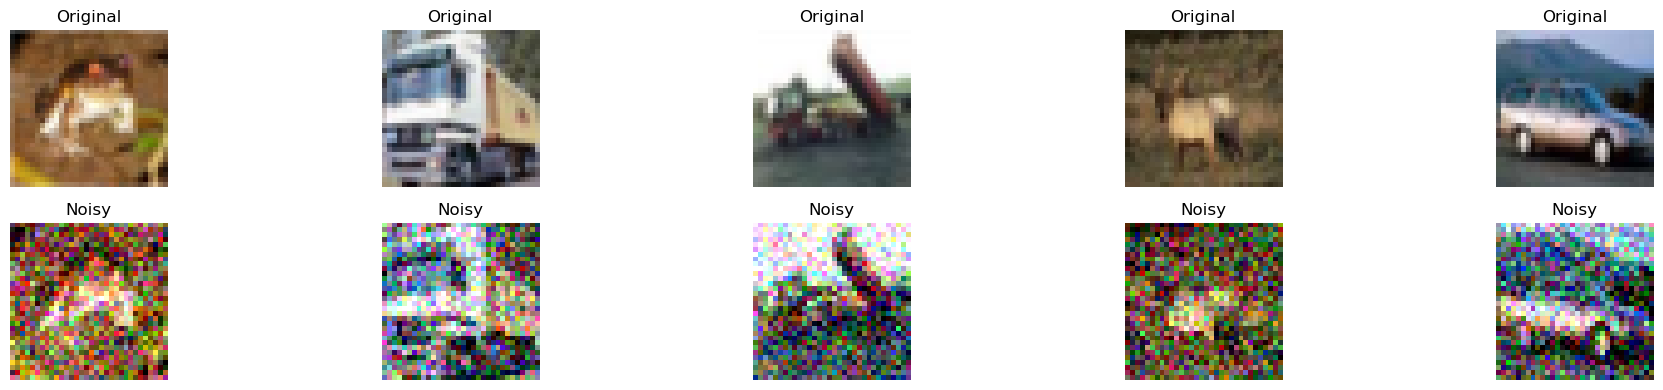

Building convolutional autoencoder...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_30               │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 4, 4, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_31               │ (None, 4, 4, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 8, 8, 64)            │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_32               │ (None, 8, 8, 64)            │             256 │
│ (BatchNormalization)                 │                             │              

 Total params: 335,747 (1.28 MB)

 Trainable params: 334,851 (1.28 MB)

 Non-trainable params: 896 (3.50 KB)

Training the autoencoder...
Epoch 1/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 66s 158ms/step - loss: 0.0195 - val_loss: 0.0118
Epoch 2/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 63s 160ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 3/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 60s 153ms/step - loss: 0.0078 - val_loss: 0.0081
Epoch 4/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 5/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 59s 150ms/step - loss: 0.0068 - val_loss: 0.0071
Epoch 6/20
391/391 ━━━━━━━━━━━━━━━━━━━━ 125s 321ms/step - loss: 0.0066 - val_loss: 0.0069
Epoch 7/20
196/391 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step - loss: 0.0064

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load and preprocess data
print("Loading and preprocessing CIFAR-10 data...")
x_train_noisy, x_train, x_test_noisy, x_test = load_and_preprocess_data(add_noise=True, noise_factor=0.2)

# Display a few noisy images
plt.figure(figsize=(20, 4))
for i in range(5):
    # Original image
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i])
    plt.title("Original")
    plt.axis("off")
    
    # Noisy image
    plt.subplot(2, 5, i + 6)
    plt.imshow(x_train_noisy[i])
    plt.title("Noisy")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Choose the model type: 'mlp' or 'conv'
model_type = 'conv'  # Change this to 'mlp' if you want to try the MLP-based autoencoder

if model_type == 'mlp':
    print("Building MLP-based autoencoder...")
    autoencoder, encoder, decoder = build_autoencoder()
else:
    print("Building convolutional autoencoder...")
    autoencoder, encoder, decoder = build_convolutional_autoencoder()

# Print model summary
autoencoder.summary()

# Train the model
print("Training the autoencoder...")
history = train_autoencoder(
    autoencoder, 
    x_train_noisy, 
    x_train, 
    x_test_noisy, 
    x_test, 
    batch_size=128, 
    epochs=20  # Reduced from 50 for quicker execution
)

# Plot training history
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
print("Evaluating the autoencoder...")
test_loss = evaluate_autoencoder(autoencoder, x_test_noisy, x_test)

# Plot reconstructed images
print("Plotting reconstructed images...")
plot_reconstructed_images(autoencoder, x_test_noisy, x_test, n=10)

print("Done!")